In [242]:
import geopandas as gpd
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier


from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, RocCurveDisplay, roc_curve, auc, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns

import shap 
import warnings
%matplotlib inline

In [243]:
RANDOM_STATE = 42

In [244]:
dados = gpd.read_file('data/generate/WGS84_hex_agg_sp_filtred.gpkg')

In [182]:
variables = ['D1_012_p', 'D1_017_p', 'D1_035_p', 'D1_044_p', "esp_1", 'area_count', "area_mean", "DCL_mean"]
categorical_variables = ['intersects_railway',	'intersects_highway', 'intersects_power', 'intersects_aeroway',	'intersects_natural', 'intersects_waterway']

In [233]:
X = dados.copy()[variables + categorical_variables]


# Convert specified columns to integer type using .loc
X.loc[:, categorical_variables] = \
    X.loc[:, categorical_variables].astype(int)
y = dados[['is_fav_comunidade']].astype(int).values.ravel()

In [184]:
X.head()

,D1_012_p,D1_017_p,D1_035_p,D1_044_p,esp_1,area_count,area_mean,DCL_mean,intersects_railway,intersects_highway,intersects_power,intersects_aeroway,intersects_natural,intersects_waterway
0,1.000000,1.000000,1.0,1.000000,114.0,63.0,147.878013,6.750791,0,0,0,0,0,0
1,1.000000,0.989796,1.0,1.000000,157.0,103.0,80.865535,10.788276,0,0,0,0,0,0
2,1.000000,1.000000,1.0,1.000000,70.0,26.0,90.313326,7.683747,0,0,0,0,0,0
3,0.996032,0.992063,1.0,0.996032,471.0,174.0,60.442236,6.340379,0,0,0,0,0,0
4,1.000000,0.640000,1.0,1.000000,20.0,47.0,180.344743,4.947622,0,0,0,0,1,0


In [185]:
# #train test split
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)


In [186]:
def apply_standard_scaler(scaler, df, columns_to_scale):
    # Copy the dataframe to avoid modifying the original
    df_scaled = df.copy()
    
    # Apply StandardScaler only to the specified columns
    df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    
    return df_scaled


In [187]:
standScaler = StandardScaler()


X_train_standScaler = apply_standard_scaler(standScaler, X_train, variables)
X_test_standScaler = apply_standard_scaler(standScaler, X_test, variables)




#X_train_standScaler = pd.DataFrame(standScaler.fit_transform(X_train), columns=X.columns)

#X_test_standScaler = pd.DataFrame(standScaler.fit_transform(X_test), columns=X.columns)


In [188]:
print(f"Size before balancing \nTraining:{X_train_standScaler.shape}, {y_train.shape}\nTeste: {X_test_standScaler.shape}, {y_test.shape}")

Size before balancing 
Training:(42847, 14), (42847, 1)
Teste: (10712, 14), (10712, 1)


In [189]:
from imblearn.over_sampling import SMOTENC

In [190]:
oversample = SMOTENC(random_state=RANDOM_STATE, sampling_strategy=0.5, categorical_features=categorical_variables)
X_train_b, y_train_b = oversample.fit_resample(X_train_standScaler, y_train)
#X_train_b, y_train_b = X_train_standScaler, y_train


In [191]:
print(f"Size after balancing \nTraining:{X_train_b.shape}, {y_train_b.shape}\nTeste: {X_test.shape}, {y_test.shape}")

Size after balancing 
Training:(63210, 14), (63210, 1)
Teste: (10712, 14), (10712, 1)


[Text(0.5, 1.0, 'Porcentagem das Classes para teste')]

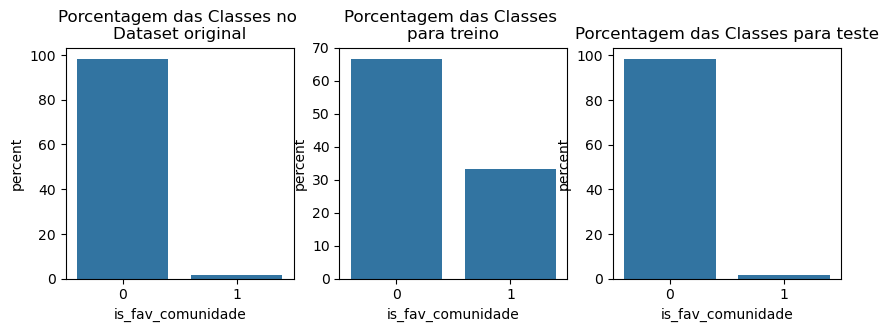

In [192]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes = axes.flatten()

sns.countplot(pd.DataFrame(y), x="is_fav_comunidade", stat="percent", ax=axes[0]).set(title="Porcentagem das Classes no \nDataset original")
sns.countplot(pd.DataFrame(y_train_b), x="is_fav_comunidade", stat="percent", ax=axes[1]).set(title="Porcentagem das Classes \npara treino")
sns.countplot(pd.DataFrame(y_test), x="is_fav_comunidade", stat="percent", ax=axes[2]).set(title="Porcentagem das Classes para teste")


# Modelagem

## Melhor modelo

In [193]:
models = {
    'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'RandomForest': RandomForestClassifier(random_state=RANDOM_STATE),
    'GradientBoosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'AdaBoost': AdaBoostClassifier(algorithm='SAMME',random_state=RANDOM_STATE),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE),
    'KNN': KNeighborsClassifier(),
    'HistGradientBoostingClassifier': HistGradientBoostingClassifier(random_state=RANDOM_STATE),
    #'CatBoostClassifier': CatBoostClassifier(random_state=RANDOM_STATE)
}

In [194]:
results_cv = {}


for name, model in models.items():
    scores = cross_validate(
        model,
        X_train_b,
        y_train_b,
        scoring=('accuracy', 'precision', 'recall', 'roc_auc', 'f1'),
        cv=10,
        return_estimator=True,
        n_jobs=-1)
    results_cv[name] = scores

/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y wa

In [195]:
resultado_simplificado = { }
resultado_simplificado_dp = {}
for key, value in results_cv.items():
  resultado_simplificado[key] =  {
      'accuracy': value['test_accuracy'].mean(),
      'precision': value['test_precision'].mean(),
      'recall' : value['test_recall'].mean(),
      'roc_auc' : value['test_roc_auc'].mean(),
      'f1' : value['test_f1'].mean(),
  }

  resultado_simplificado_dp[key] =  {
      'accuracy': value['test_accuracy'].std(),
      'precision': value['test_precision'].std(),
      'recall' : value['test_recall'].std(),
      'roc_auc' : value['test_roc_auc'].std(),
      'f1' : value['test_f1'].std(),
  }

  print(f"{key} CV accuracy: {resultado_simplificado[key]['accuracy']} ± {resultado_simplificado_dp[key]['accuracy']}")
  print(f"{key} CV precision: {resultado_simplificado[key]['precision']} ± {resultado_simplificado_dp[key]['precision']}")
  print(f"{key} CV recall: {resultado_simplificado[key]['recall']} ± {resultado_simplificado_dp[key]['recall']}")
  print(f"{key} CV roc_auc: {resultado_simplificado[key]['roc_auc']} ± {resultado_simplificado_dp[key]['roc_auc']}")
  print(f"{key} CV f1: {resultado_simplificado[key]['f1']} ± {resultado_simplificado_dp[key]['f1']}")




DecisionTree CV accuracy: 0.957063755734852 ± 0.0063012402059738504
DecisionTree CV precision: 0.9285480002731582 ± 0.0043384479806128345
DecisionTree CV recall: 0.9438538205980066 ± 0.02036512719330359
DecisionTree CV roc_auc: 0.9554134533362136 ± 0.010358332019612494
DecisionTree CV f1: 0.9360163737834137 ± 0.010314725115499657
RandomForest CV accuracy: 0.9801139060275273 ± 0.006598043750344648
RandomForest CV precision: 0.9612629324807447 ± 0.002836296792055912
RandomForest CV recall: 0.9798291409587092 ± 0.02005213672081013
RandomForest CV roc_auc: 0.9973033083610151 ± 0.0009358768969662905
RandomForest CV f1: 0.9703539669481632 ± 0.01035849993330147
GradientBoosting CV accuracy: 0.9172915677899066 ± 0.0030764651820741687
GradientBoosting CV precision: 0.8667718331262065 ± 0.007074276137584442
GradientBoosting CV recall: 0.888609397247271 ± 0.01376045329014518
GradientBoosting CV roc_auc: 0.9732326860833405 ± 0.0019595975431468565
GradientBoosting CV f1: 0.8774513032490457 ± 0.0054

In [196]:
mean_results = pd.DataFrame(resultado_simplificado)
std_results = pd.DataFrame(resultado_simplificado_dp)

In [197]:
mean_results.head()

,DecisionTree,RandomForest,GradientBoosting,AdaBoost,XGBoost,KNN,HistGradientBoostingClassifier
accuracy,0.957064,0.980114,0.917292,0.880857,0.968312,0.959737,0.950229
precision,0.928548,0.961263,0.866772,0.829490,0.936814,0.899094,0.904517
recall,0.943854,0.979829,0.888609,0.809255,0.970432,0.990413,0.951163
roc_auc,0.955413,0.997303,0.973233,0.949983,0.994478,0.987557,0.988989
f1,0.936016,0.970354,0.877451,0.819054,0.953248,0.942534,0.927168


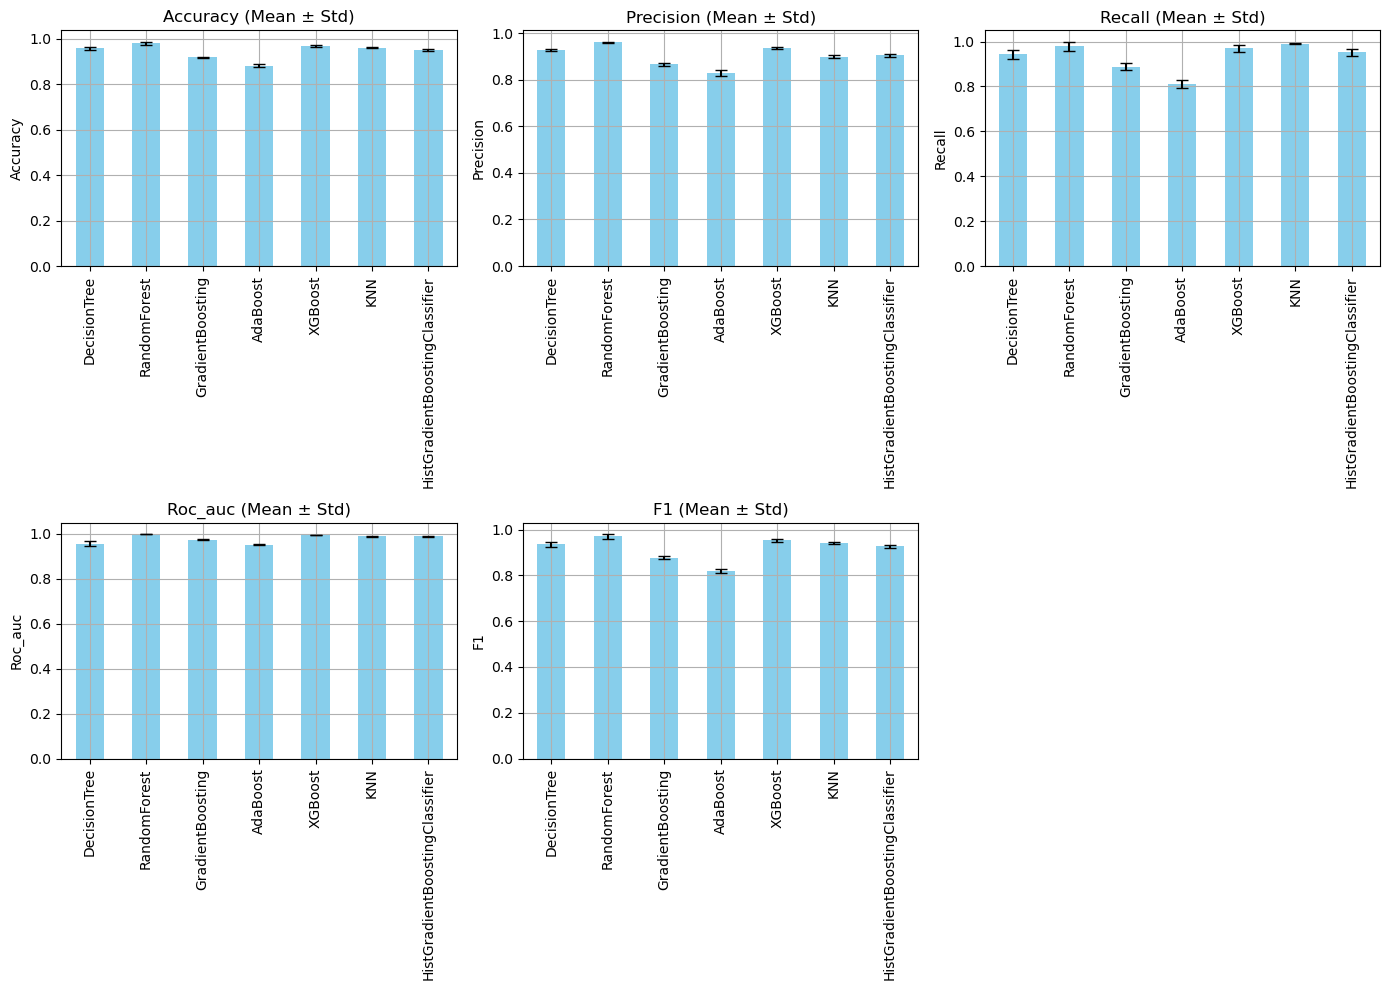

In [198]:
# Plotando a média e o desvio padrão lado a lado
fig, axes = plt.subplots(2, 3, figsize=(14, 10))
axes = axes.flatten()
metrics = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1']

for i, metric in enumerate(metrics):
    ax = axes[i]
    mean_values = mean_results.loc[metric]
    std_values = std_results.loc[metric]
    
    mean_values.plot(kind='bar', yerr=std_values, ax=ax, capsize=4, color='skyblue')
    ax.set_title(f'{metric.capitalize()} (Mean ± Std)')
    ax.set_ylabel(metric.capitalize())
    ax.grid(True)

# Hide any unused axes
for j in range(len(metrics), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [199]:
from scipy.stats import ttest_rel

# Define the models to compare (DecisionTree and XGBoost)
models_to_test = ['DecisionTree', 'XGBoost', 'RandomForest']

# Create an empty list to store the test results
results_list = []

# Function to perform the paired t-test and append results to the list
def perform_t_test(reference_model, target_model, metric='test_roc_auc'):
    ref_scores = results_cv[reference_model][metric]
    target_scores = results_cv[target_model][metric]
    
    # Perform paired t-test
    t_stat, p_value = ttest_rel(ref_scores, target_scores)
    
    # Determine whether to reject the null hypothesis
    confidence_level = 0.95
    significant = 'Yes' if p_value < (1 - confidence_level) else 'No'
    
    # Append the result to the list
    results_list.append({
        'Reference Model': reference_model,
        'Compared Model': target_model,
        'Metric': metric,
        'T-statistic': t_stat,
        'P-value': p_value,
        'Significant Difference (95%)': significant
    })

# Loop through all models and compare with DecisionTree and XGBoost
for ref_model in models_to_test:
    for model_name in results_cv.keys():
        if model_name != ref_model:  # Avoid comparing the model with itself
            perform_t_test(ref_model, model_name, 'test_recall')

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_list)

# Display the DataFrame

results_df


,Reference Model,Compared Model,Metric,T-statistic,P-value,Significant Difference (95%)
0,DecisionTree,RandomForest,test_recall,-35.273836,5.847781e-11,Yes
1,DecisionTree,GradientBoosting,test_recall,18.595525,1.723998e-08,Yes
2,DecisionTree,AdaBoost,test_recall,32.511194,1.212020e-10,Yes
3,DecisionTree,XGBoost,test_recall,-13.617643,2.604506e-07,Yes
4,DecisionTree,KNN,test_recall,-7.206636,5.046850e-05,Yes
5,DecisionTree,HistGradientBoostingClassifier,test_recall,-3.640618,5.395697e-03,Yes
6,XGBoost,DecisionTree,test_recall,13.617643,2.604506e-07,Yes
7,XGBoost,RandomForest,test_recall,-5.305263,4.904337e-04,Yes
8,XGBoost,GradientBoosting,test_recall,36.641247,4.161673e-11,Yes
9,XGBoost,AdaBoost,test_recall,48.326169,3.486549e-12,Yes


# Melhor Modelo

In [200]:
def model_eval(model,X_train,y_train,X_test,y_test,classes=None,
                           normalize='true',cmap='Blues',label=''):

    """Example function with PEP 484 type annotations.

        Args:
            model: The Model Classifier.
            X_train: X_train being used to fit model (could be scaled or not).
            y_train: y_train being used to fit model and to get train accuracy.
            X_test: X_test to get test predictions.
            y_test: y_test used to get test accuracy

        Returns:
            Model Accuracy. Confusion Matrix, ROC Curve, and best params for GridSearch

    """
    
    
    #FITTING MODEL WITH TRAIN DATA
    model.fit(X_train,y_train)   
      
    #GETTING TRAIN PREDICTIONS
    y_hat_train = model.predict(X_train)
    
    #GETING TEST PREDICTIONS
    y_hat_test = model.predict(X_test)
    
    dashes = '---'*20
    
    if isinstance(model,GridSearchCV):
        grid_header = "GRID SEARCH FOUND THE FOLLOWING OPTIMAL PARAMETERS: "
        print(dashes,grid_header,dashes,sep='\n')
        best_parameters = model.best_params_
        for param_name in sorted(best_parameters.keys()):
            print("%s: %r" % (param_name, best_parameters[param_name]))
    
    #GETTING ACCURACY SCORE FOR TRAIN AND TEST
    
    if len(label)>0:
        accuracy_header = f'{label} ACCURACY'
    else:
        accuracy_header = 'MODEL ACCURACY'
    print(dashes,accuracy_header,dashes,sep='\n')
    training_accuracy = accuracy_score(y_train, y_hat_train)
    testing_accuracy = accuracy_score(y_test, y_hat_test)
    
    print(f'TRAINING ACCURACY: {round(training_accuracy*100,2)}%')
    print(f'TESTING ACCURACY: {round(testing_accuracy*100,2)}%')
    
     
    if len(label)>0:
        accuracy_header = f'{label} RECALL'
    else:
        accuracy_header = 'MODEL RECALL'

    print(dashes,accuracy_header,dashes,sep='\n')
    training_recall = recall_score(y_train, y_hat_train)
    testing_recall = recall_score(y_test, y_hat_test)
    
    print(f'TRAINING RECALL: {round(training_recall*100,2)}%')
    print(f'TESTING RECALL: {round(testing_recall*100,2)}%')

    #CLASSIFICATION REPORT AND SCORES
    test_header = "CLASSIFICATION REPORT"
    
    #ADDING LABEL IF GIVEN
    if len(label)>0:
        test_header += f" USING {label}"
    
    # PRINT CLASSIFICATION REPORT
    
    print(dashes,test_header,dashes,sep='\n')

    print(classification_report(y_test,y_hat_test,
                                    target_names=classes))

    print(dashes+"\n\n")
    
    

    # MAKE FIGURE
    fig, axes = plt.subplots(figsize=(10,4),ncols=2)
    
    # PLOTTING CONFUSION MATRIX 

    
    #cm = confusion_matrix(, labels=model.classes_)
    ConfusionMatrixDisplay.from_predictions(y_test, y_hat_test, labels=model.classes_, ax=axes[0], cmap=cmap)
    axes[0].set(title='Confusion Matrix')
    
    #PLOTTING ROC CURVE
    fpr, tpr, thresholds = roc_curve(y_test, y_hat_test)
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay.from_predictions(y_test, y_hat_test, ax=axes[1])
    axes[1].set_title('Receiving Operator Characteristic (ROC) Curve') 
    #fig.tight_layout()
    
    
    plt.show()


### Random Forest

In [201]:
param_grid_random_forest = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [10, 50],
    'class_weight': [None, 'balanced']
}

param_grid_random_forest = {
    #'class_weight': [None, 'balanced'],
   
}

In [202]:
grid_search_RandomForest = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE),
    param_grid_random_forest,
    cv=10,
    scoring='recall',
    n_jobs=-1,
    verbose=3
    )
grid_search_RandomForest.fit(X_train_b, y_train_b)

print("Melhores parametros Para  RandomForestClassifier:", grid_search_RandomForest.best_params_)
print("Melhor CV recall para RandomForestClassifier:", grid_search_RandomForest.best_score_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y wa

[CV 2/10] END .................................., score=0.989 total time=  14.8s
[CV 1/10] END .................................., score=0.920 total time=  14.9s
[CV 3/10] END .................................., score=0.983 total time=  14.9s
[CV 4/10] END .................................., score=0.989 total time=  14.9s
[CV 5/10] END .................................., score=0.988 total time=  14.9s
[CV 6/10] END .................................., score=0.989 total time=  14.9s
[CV 8/10] END .................................., score=0.986 total time=  14.8s
[CV 9/10] END .................................., score=0.985 total time=  14.8s
[CV 10/10] END ................................., score=0.989 total time=  14.8s
[CV 7/10] END .................................., score=0.981 total time=  15.0s


/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Melhores parametros Para  RandomForestClassifier: {}
Melhor CV recall para RandomForestClassifier: 0.9798291409587092


In [203]:
model_grid_search_RandomForest = grid_search_RandomForest.best_estimator_

/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


------------------------------------------------------------
RandomForest ACCURACY
------------------------------------------------------------
TRAINING ACCURACY: 99.85%
TESTING ACCURACY: 77.08%
------------------------------------------------------------
RandomForest RECALL
------------------------------------------------------------
TRAINING RECALL: 99.91%
TESTING RECALL: 87.33%
------------------------------------------------------------
CLASSIFICATION REPORT USING RandomForest
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.77      0.87     10562
           1       0.05      0.87      0.10       150

    accuracy                           0.77     10712
   macro avg       0.52      0.82      0.48     10712
weighted avg       0.98      0.77      0.86     10712

------------------------------------------------------------




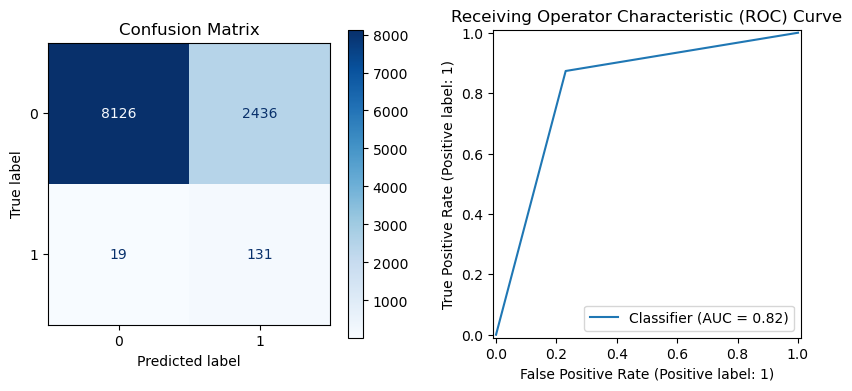

In [204]:
model_eval(model_grid_search_RandomForest,X_train_b, y_train_b, X_test_standScaler, y_test,label='RandomForest')

In [205]:
X_train_b

,D1_012_p,D1_017_p,D1_035_p,D1_044_p,esp_1,area_count,area_mean,DCL_mean,intersects_railway,intersects_highway,intersects_power,intersects_aeroway,intersects_natural,intersects_waterway
0,0.062799,-2.418364,0.100730,0.054660,0.323628,2.148400,-0.550796,-1.311045,0,0,0,0,0,1
1,0.065423,-2.242913,0.100730,0.058035,-0.224702,0.847495,-0.473708,-1.311045,0,0,0,0,0,1
2,0.180901,0.478469,0.100730,0.206534,-0.476020,-0.005557,0.033142,-1.311045,0,0,0,0,0,0
3,0.180901,0.359458,0.100730,0.047427,0.449286,1.935137,-0.401788,-0.105031,0,0,0,0,0,0
4,-0.511967,0.145238,0.100730,0.206534,-0.910114,-1.327789,-0.123199,0.312378,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63205,0.180901,0.478469,0.100730,0.206534,1.654232,1.618241,-0.482434,1.329047,0,0,0,0,0,0
63206,0.180901,-3.888354,0.100730,-0.455569,-0.351421,-0.061817,-0.413643,0.893852,0,0,0,0,0,0
63207,0.180901,-2.987728,0.100730,0.201709,1.664911,2.242391,-0.694950,0.043343,0,0,0,0,0,0
63208,0.033115,-0.074269,0.100730,-0.540916,0.048817,0.465229,-0.373768,2.256127,0,0,0,0,0,0


#### Model Results

In [206]:
standScalerAll = StandardScaler()
x_all = apply_standard_scaler(standScalerAll, X, variables)

In [207]:
y_all_hat = model_grid_search_RandomForest.predict_proba(x_all)
y_all_hat_val = model_grid_search_RandomForest.predict(x_all)


In [208]:
sao_remo_poli = dados[dados['id_hex'] == '8aa81005aadffff'].index[0]
oscar_freire = dados[dados['id_hex'] == '8aa8100ea147fff'].index[0]

buracana = dados[dados['id_hex'] == '8aa81005aa8ffff'].index[0]

test = dados[dados['id_hex'] == '8aa8103b4a37fff'].index[0]

In [209]:
y_all_hat[buracana]

array([0.43, 0.57])

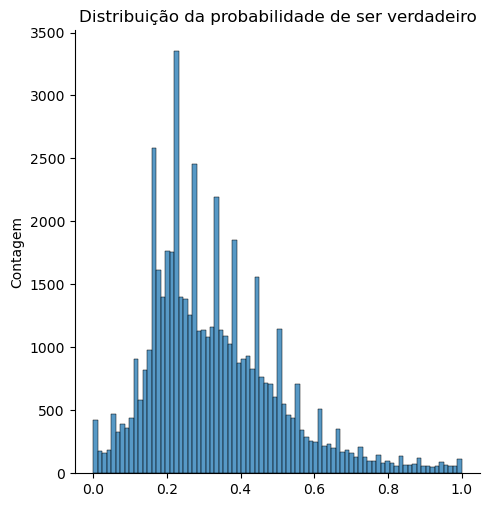

In [210]:
sns.displot(y_all_hat[:, 1]). set(title='Distribuição da probabilidade de ser verdadeiro', ylabel='Contagem')


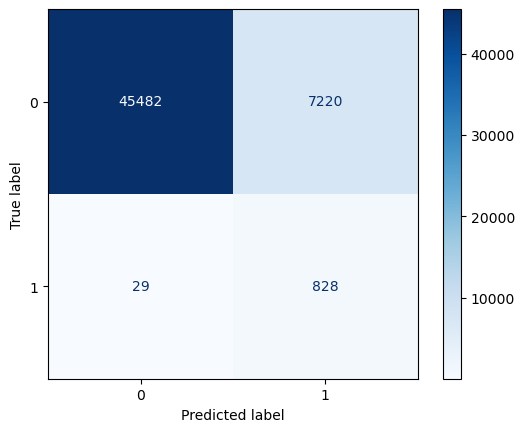

In [211]:

# PLOTTING CONFUSION MATRIX 
   
ConfusionMatrixDisplay.from_predictions(y, y_all_hat_val, labels=model_grid_search_RandomForest.classes_, cmap='Blues')

# Shape Random Forest

In [212]:
explainer = shap.TreeExplainer(model_grid_search_RandomForest, X_train_b)
shap.plots.initjs()

In [213]:
explainer.expected_value

array([0.62643667, 0.37356333])

In [214]:
shap_values = explainer(x_all)

100%|===================| 107107/107118 [108:07<00:00]        

In [215]:
shap_values.shape

(53559, 14, 2)

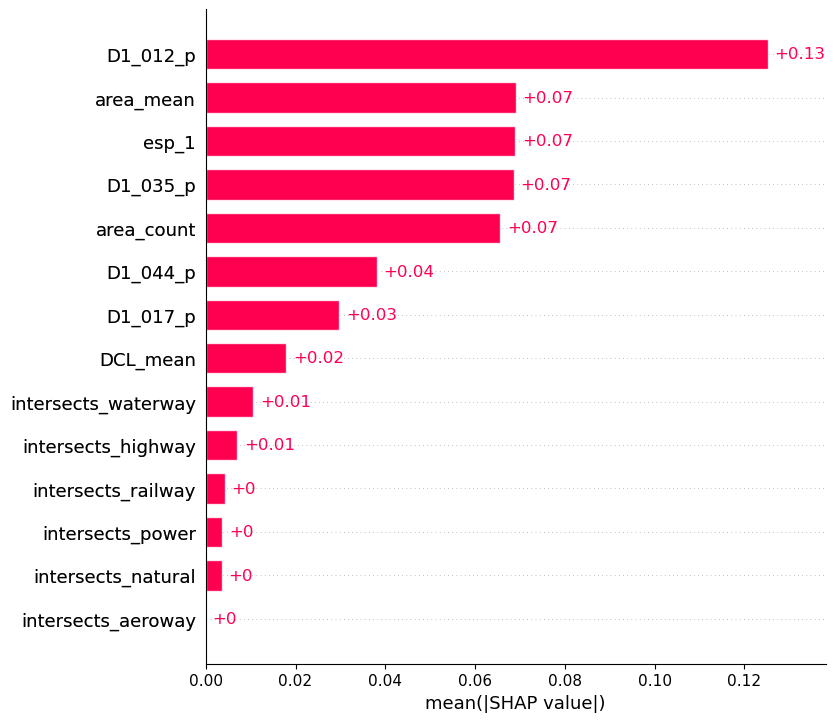

In [216]:
shap.plots.bar(shap_values[:, :, 1], max_display=16)

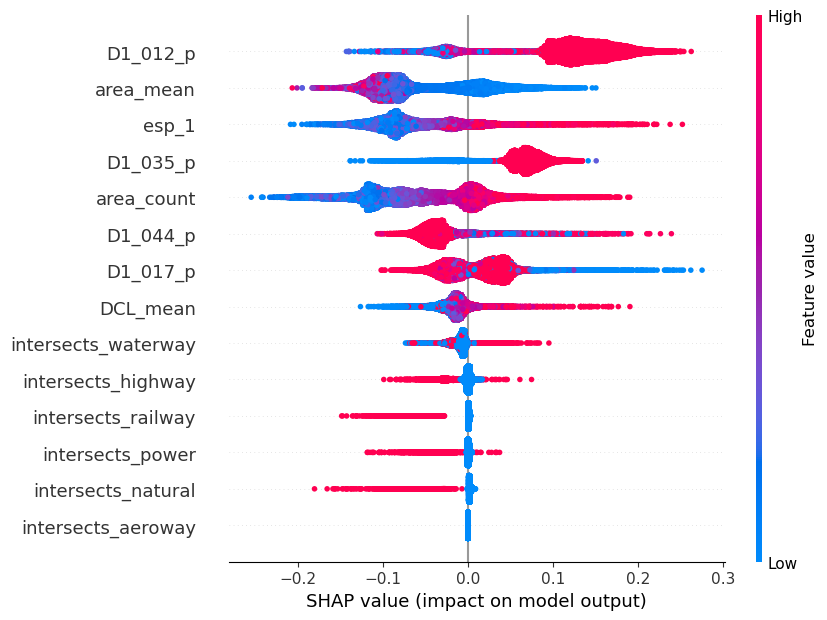

In [250]:
shap.plots.beeswarm(shap_values[:, :, 1], max_display=16)


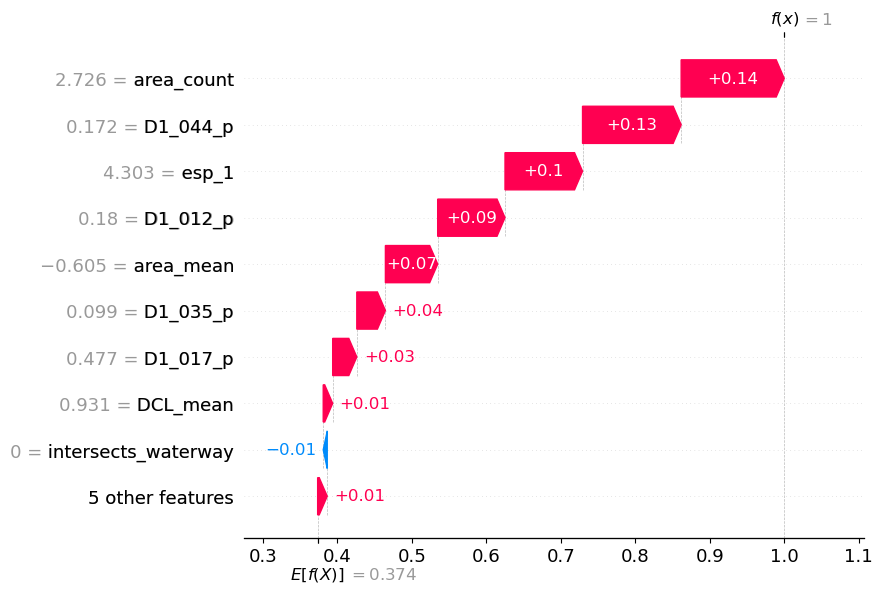

In [218]:
# São Remo poligono 
shap.plots.waterfall(shap_values[sao_remo_poli, :, 1])

In [222]:
shap.force_plot(explainer.expected_value[1], shap_values[buracana, :, 1].values, feature_names=(x_all.columns))

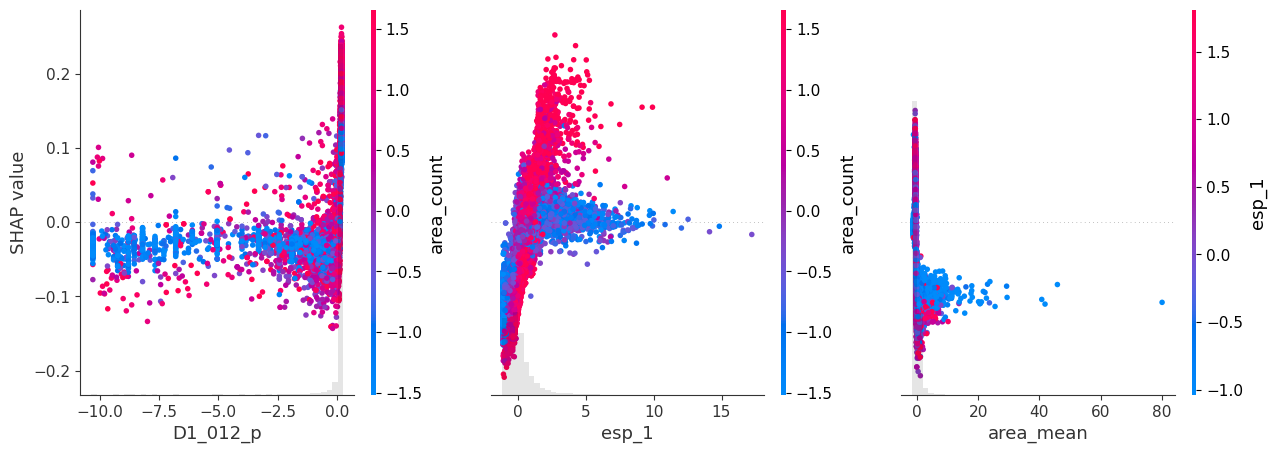

In [220]:

shap.plots.scatter(shap_values[:, ['D1_012_p', 'esp_1', 'area_mean'], 1], color=shap_values[:, :, 1])



In [236]:
condition_outlier = y_all_hat_val == 1
qnt_pred_as_true = condition_outlier.sum()

true_pred =  sum(y[y_all_hat_val == 1])

print(qnt_pred_as_true, true_pred)

8048 828


In [237]:
falso_positivo_condition = ((y_all_hat_val == 1) & (y == 0))
falso_negativo_condition = (y_all_hat_val  == 0) & (y == 1)
true_condition = (y_all_hat_val == 1) & (y == 1)
false_condition = (y_all_hat_val == 0) & (y == 0)


### Analise dos erros tipo i e ii


In [165]:
# Analise falso positivo
T = x_all[falso_positivo_condition]
sh_fp = explainer(T)


100%|===================| 11063/11074 [11:01<00:00]        

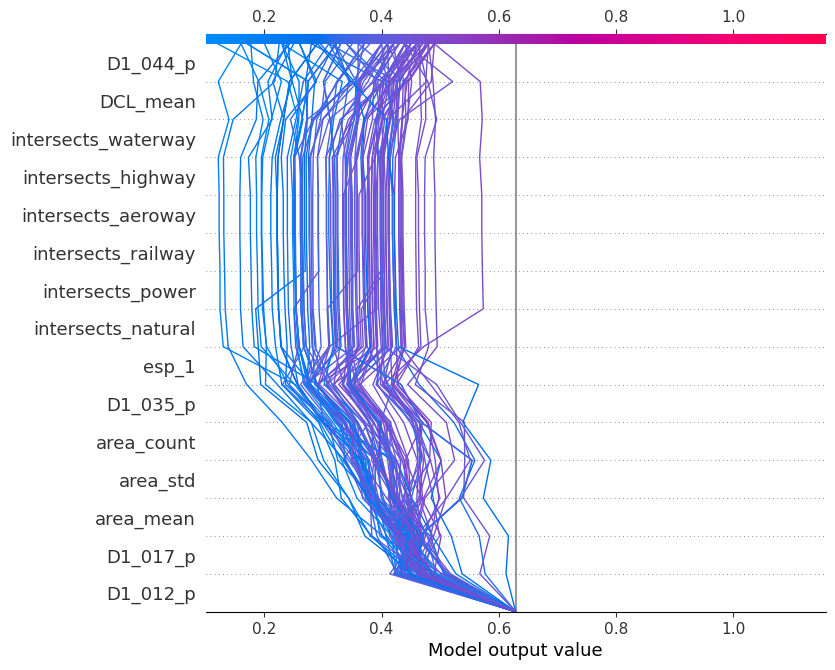

In [166]:
with warnings.catch_warnings():
    r = shap.decision_plot(explainer.expected_value[0], sh_fp[:100, :, 0].values, T[:100], feature_order="hclust", return_objects=True, ignore_warnings=True)

In [167]:
# Analise falso negativo
T = x_all[falso_negativo_condition]
sh_fn = explainer(T)


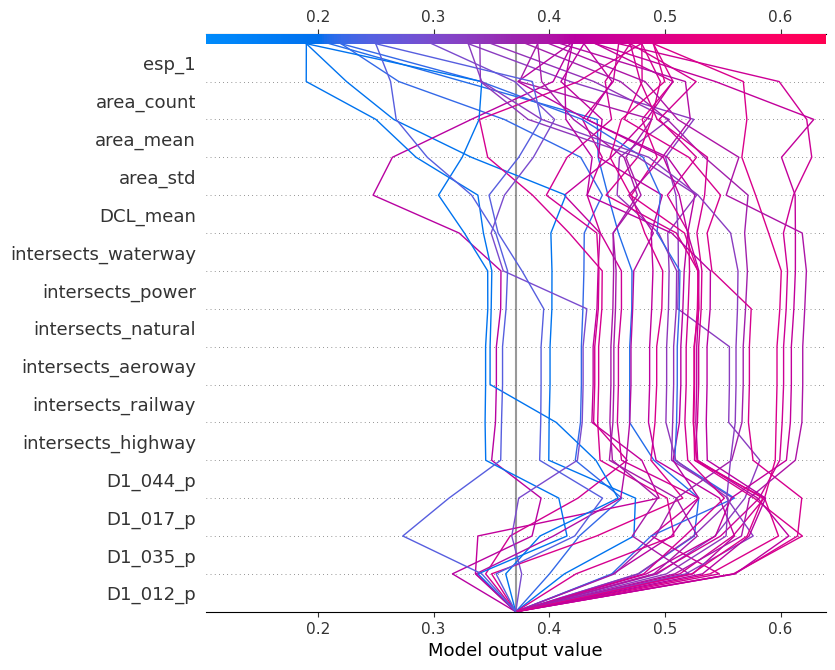

In [168]:
r = shap.decision_plot(explainer.expected_value[1], sh_fn[:, :, 1].values, T, feature_order="hclust", return_objects=True)

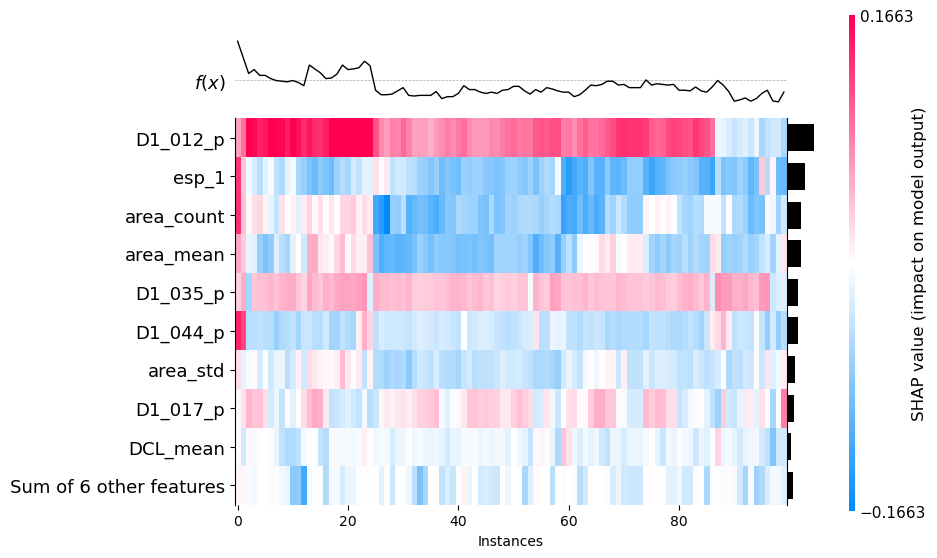

<Axes: xlabel='Instances'>

In [169]:
shap.plots.heatmap(shap_values[:100, : , 1])

In [238]:
import pickle

# Assuming `shap_values` is the result from `explainer(x_all)`
with open("data/model/shap_values_model_sem_iptu.pkl", "wb") as file:
    pickle.dump(shap_values, file)

## Saving probability and classification

In [245]:
dados['is_fav_prob_model1'] = y_all_hat[:, 1]

dados.loc[falso_positivo_condition, 'model1_result'] = 'FP'
dados.loc[falso_negativo_condition, 'model1_result'] = 'FN'
dados.loc[true_condition, 'model1_result'] = 'P'
dados.loc[false_condition, 'model1_result'] = 'N'


In [249]:
dados.to_file("data/generate/WGS84_hex_sp_model_sempitu.gpkg", driver="GPKG")